# XGBoost Wind Prediction

Paper: https://doi.org/10.1016/j.egypro.2016.12.147

Time interval: short term (20 seconds)

Method used: Multivariable based ANN. 

Data used: https://www.kaggle.com/depekha/wind-turbine-scada-dataset/data

Multiple local meteorological meassurements:
 - wind speed
 - temperature
 - pressure
 - lead time (when we want to predict wind speed)
 
Models used:
 - data: wind speed
 - data: wind speed + temperature 
 - data: wind speed + temperature + pressure

Depth of data used for training: five days back since today

Performance meassurements:
 - Root Mean Square Error
 - Mean Absolute Error

## Observations

Cosas a mejorar del paper

## Código

### Librerías

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.neural_network import MLPRegressor as reg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as rmse
from sklearn .metrics import mean_absolute_error as mae

### Funciones

In [2]:
# Formatea las variables de tal forma que las pueda admitir la ANN
def fix_ANN_parameters(X, m, delta):
    tam = X.size - delta
    X_fixed = []
    y_fixed = X[delta:]
    for i in range(tam):
        X_fixed = np.append(X_fixed, X[i:(i + m)])
    X_fixed = np.reshape(X_fixed, (tam, m))
    
    return X_fixed, y_fixed

### Preparamos los datos 

In [3]:
# Extraemos los datos del .csv
filename = 'T1.csv'
col_list = ["Date/Time", "Wind Speed (m/s)"]
data = pd.read_csv('T1.csv', usecols=col_list)

data

,Date/Time,Wind Speed (m/s)
0,01 01 2018 00:00,5.311336
1,01 01 2018 00:10,5.672167
2,01 01 2018 00:20,5.216037
3,01 01 2018 00:30,5.659674
4,01 01 2018 00:40,5.577941
...,...,...
50525,31 12 2018 23:10,11.404030
50526,31 12 2018 23:20,7.332648
50527,31 12 2018 23:30,8.435358
50528,31 12 2018 23:40,9.421366


In [4]:
# Ahora obtenemos el parámetro que necesitemos; en este caso, la wind speed. Ésta será nuestra variable X
np_data = data.to_numpy()
X = np_data[:,1]

X

array([5.31133604049682, 5.67216682434082, 5.21603679656982, ...,
       8.43535804748535, 9.42136573791503, 9.97933197021484], dtype=object)

In [5]:
# A continuación, dividimos los datos en un dataset para entrenar la ANN y en otro para probar su rendimiento
X_train, X_test = train_test_split(X, test_size=0.4, shuffle=False)

np.shape(X_train), np.shape(X_test)

((30318,), (20212,))

In [6]:
# Antes de empezar, tenemos que escoger el tamaño de muestra m con el que queremos entrenar nuestra ANN, teniendo
# en cuenta que cada muestra representa la velocidad del aire media en un intervalo de 10 minutos
m = 6 * 24 # 1 semana
# A continuación, para seleccionar correctamente nuestra variable y tenemos que decidir para dentro de cuanto
# tiempo queremos predecir la velocidad del tiempo; es decir, delta. Para ese entrenamiento, hemos escogido una
# delta = 30 o, lo que es lo mismo, 5 minutos
delta = m + 6

In [7]:
# Damos formato a los datos de entrenamiento
X_train_fixed, y_train_fixed = fix_ANN_parameters(X_train, m, delta)

np.shape(X_train_fixed),np.shape(y_train_fixed)

dtrain  = xgb.DMatrix(X_train_fixed, label=y_train_fixed)

In [8]:
# Damos formato a los datos de prueba
X_test_fixed, y_test_fixed = fix_ANN_parameters(X_test, m, delta)

np.shape(X_test_fixed),np.shape(y_test_fixed)

dtest = xgb.DMatrix(X_test_fixed, label=y_test_fixed)

### Entrenamos la ANN

In [20]:
# Establecemos los parametros del algoritmo
param = {'max_depth': 2, 'eta': 1, 'eval_metric' : 'mae'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 10
# Entrenemos la ANN
bst = xgb.train(param, dtrain, num_round, evallist)

# Veamos que tal funciona
bst.predict(xgb.DMatrix(X_train_fixed[:1])), y_train_fixed[1]

[0]	eval-mae:1.52421	train-mae:1.57215
[1]	eval-mae:1.48707	train-mae:1.48932
[2]	eval-mae:1.32578	train-mae:1.39923
[3]	eval-mae:1.22250	train-mae:1.31360
[4]	eval-mae:1.19085	train-mae:1.26526
[5]	eval-mae:1.19039	train-mae:1.25767
[6]	eval-mae:1.18670	train-mae:1.25262
[7]	eval-mae:1.18926	train-mae:1.25032
[8]	eval-mae:1.18983	train-mae:1.24915
[9]	eval-mae:1.19071	train-mae:1.24642


(array([11.6225395], dtype=float32), 12.1961202621459)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

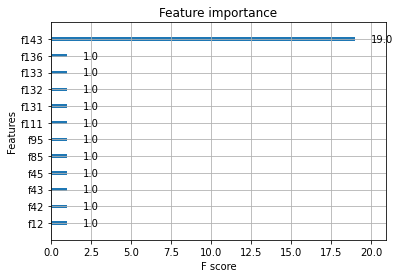

In [14]:
xgb.plot_importance(bst)

ImportError: You must install graphviz to plot tree

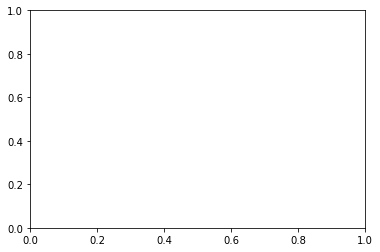

In [15]:
xgb.plot_tree(bst, num_trees=2)

### Probamos la ANN

### Aplicamos las medidas de rendimiento 

En este caso, dichas medidas son la root mean square error (RMSE) y la mean absolute error (MAE)

#### Root Mean Square Error

In [10]:
#rmse(y_test_fixed, y_test_predicted, squared= False)

In [11]:
#mae(y_test_fixed, y_test_predicted)